In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse

import torch
from   torch.utils import data
from data.data_utils import Dataset

/Users/ilze/PhD/virtualenv/env3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Compare LV results

### load data

In [7]:
data_path_test = 'data/lv/lv-te-data-clean.pkl'
data_path_train = 'data/lv/lv-tr-data-clean.pkl'
device = 'cpu'
dtype = torch.float64
batch_size = 20
shuffle = True
num_workers = 0
Ntrain = 500

In [6]:
X_te = torch.load(data_path_test)
X_te = X_te.to(device).to(dtype)
X_tr = torch.load(data_path_train)
X_tr = X_tr.to(device).to(dtype)

In [8]:
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_workers, 'drop_last': True}
trainset = Dataset(X_tr)
trainset = data.DataLoader(trainset, **params)
testset  = Dataset(X_te)
testset  = data.DataLoader(testset, **params)

### load models

In [9]:
from model.core.invodevae import INVODEVAE
from model.core.flow import Flow
from model.core.vae import VAE
from model.core.mlp import MLP
from model.core.inv_enc import INV_ENC

##### Node + inv + contrastive

In [10]:
T_in = 8
T_inv = 40
ode_latent_dim = 8
inv_latent_dim = 8
order = 1 
D_in  = ode_latent_dim + inv_latent_dim
D_out = int(ode_latent_dim / order)
solver = 'euler'
use_adjoint = False
frames = 5
dt = 0.1
aug = True
Nobj = 1
task ='lv'
n_filt = 8 
num_layers = 2 
num_hidden = 200
rnn_hidden = 10
decoder_H = 100
dec_act = 'relu'
cnn_arch = 'dcgan'
last_layer_gp  = None

In [11]:
node_inv_contr = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        num_observations = Ntrain,
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)


In [12]:
node_inv_contr.to(device)
fname = 'results/lv/21_01_2023-20:33/invodevae.pth'
node_inv_contr.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_inv_contr.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=16, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=8, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): EncoderRNN(
      (sp): Softplus(beta=1, threshold=20)
      (gru): GRUEncoder(
        (rnn_hidden_to_latent): Sequential(
          (0): Linear(in_features=10, out_features=50, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=50, out_features=16, bias=True)
        )
        (gru): GRU(2, 10)
      )
    )
    (decoder): Decoder(
      (net): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=8, out_features=100, bias=True)
      

##### Node + inv 

In [13]:
node_inv = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        num_observations = Ntrain,
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

In [14]:
node_inv.to(device)
fname = 'results/lv/21_01_2023-21:17/invodevae.pth'
node_inv.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_inv.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=16, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=8, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): EncoderRNN(
      (sp): Softplus(beta=1, threshold=20)
      (gru): GRUEncoder(
        (rnn_hidden_to_latent): Sequential(
          (0): Linear(in_features=10, out_features=50, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=50, out_features=16, bias=True)
        )
        (gru): GRU(2, 10)
      )
    )
    (decoder): Decoder(
      (net): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=8, out_features=100, bias=True)
      

##### Node 

In [15]:
T_in = 40
inv_latent_dim=0
D_in = ode_latent_dim
D_out = int(D_in/order)
aug=False
node_base= INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = None,
                        num_observations = Ntrain,
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

In [16]:
node_base.to(device)
fname = 'results/lv/21_01_2023-21:18/invodevae.pth'
node_base.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_base.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=8, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=8, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): EncoderRNN(
      (sp): Softplus(beta=1, threshold=20)
      (gru): GRUEncoder(
        (rnn_hidden_to_latent): Sequential(
          (0): Linear(in_features=10, out_features=50, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=50, out_features=16, bias=True)
        )
        (gru): GRU(2, 10)
      )
    )
    (decoder): Decoder(
      (net): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=8, out_features=100, bias=True)
       

##### plot results

In [130]:
def plot_C(C):
    '''
    C - embeddings L, N, T, q
    N, T, q - size of tensors
    '''
    C = C.mean(0) if C.ndim==4 else C
    N_,T_,q_ = C.shape
    C = C.reshape(N_*T_,q_) # NT,q

    diff = C.unsqueeze(0) - C.unsqueeze(1) # NT,NT,q pairwise diffs
    dist = diff.pow(2).sum(2).sqrt()

    plt.figure(1,(12,9))
    plt.imshow(dist.detach().cpu().numpy())
    plt.colorbar()

    
    C_ = C / C.pow(2).sum(1,keepdim=True).sqrt() # normalized features
    theta = (C_.unsqueeze(0) * C_.unsqueeze(1)).sum(2) # NT,NT angle between features

    plt.figure(2,(12,9))
    plt.imshow(theta.detach().cpu().numpy())
    plt.colorbar()

In [17]:
from model.misc.plot_utils import plot_2d, plot_2d_origin, plot_latent_traj

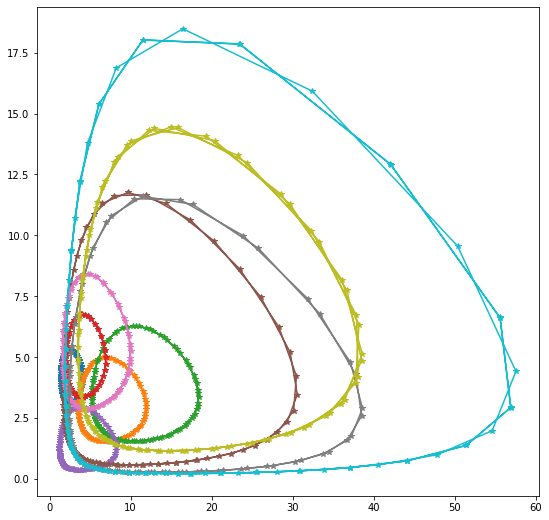

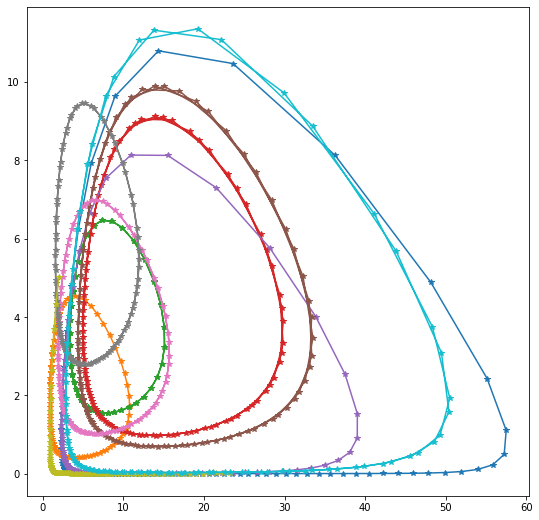

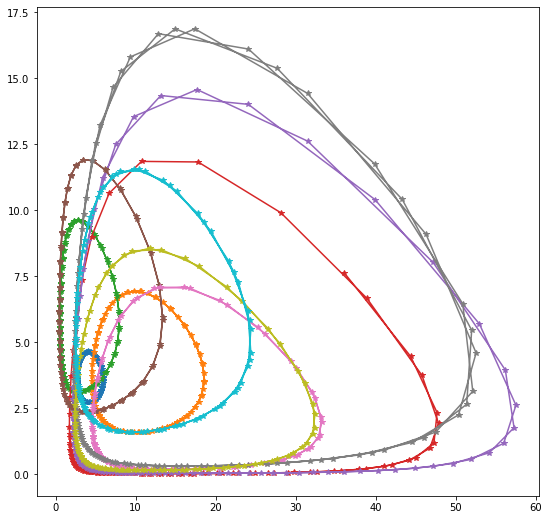

In [99]:
for test_batch in testset:
    plot_2d_origin(test_batch, show=True)

In [133]:
plotL= 5
forecast_te = 2

##### Node+ inv +cont

In [136]:
Xrec_te, ztL_te, _, _, C_full = node_inv_contr(test_batch,   L=plotL, T_custom=forecast_te*test_batch.shape[1])

In [134]:
import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.keys())
def plot_2d(X, Xrec, show=False, fname='predictions.png', N=None, D=None, C=2, L=None):
    ''' 
        For spiral and lv dataset (d=2)
        X    - [N,T,d] 
        Xrec - [L,N,Ttest,d]
    '''
    palette_t = palette[1:]
    if N is None:
        N = min(X.shape[0],3)
    if D is None:
        D = min(X.shape[-1],3)
    if L is None:
        L = Xrec.shape[0]
    Xnp    = X.detach().cpu().numpy()
    Xrecnp = Xrec.detach().cpu().numpy()
    fig, axs = plt.subplots(N, C, figsize=(9, 9))
    nidx = 0
    for n in range(N):
        for c in range(C):
            axs[n,c].plot(Xnp[nidx,:,0], Xnp[nidx,:,1], '-', color='tab:blue')
            for l in range(L):
                axs[n,c].plot(Xrecnp[l,nidx,:,0],Xrecnp[l,nidx,:,1], '--', color=palette_t[l])
            nidx +=1
    
    for ax in axs.flat:
        ax.label_outer()
    if show:
        plt.show()
    else:
        plt.savefig(fname)
        plt.close()

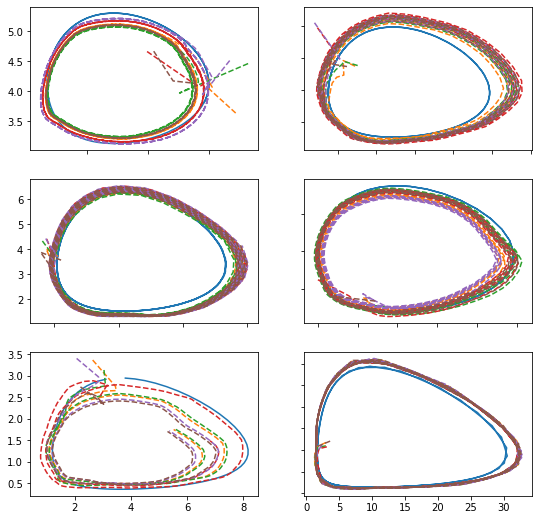

In [137]:
plot_2d(test_batch, Xrec_te, show=True)

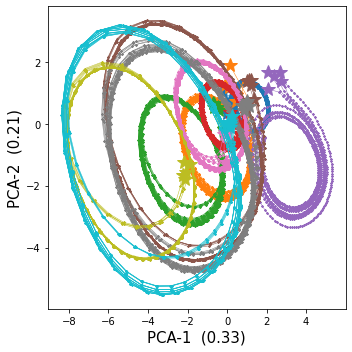

In [138]:
plot_latent_traj(ztL_te, show=True)

##### Node+ inv

In [139]:
Xrec_te, ztL_te, _, _, C_inv = node_inv(test_batch,   L=plotL, T_custom=forecast_te*test_batch.shape[1])

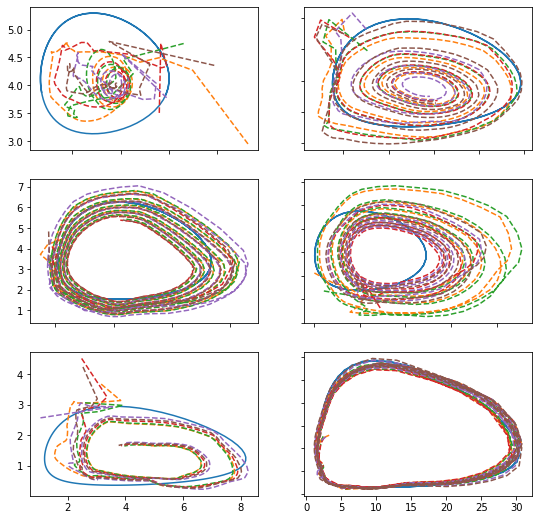

In [140]:
plot_2d(test_batch, Xrec_te, show=True)

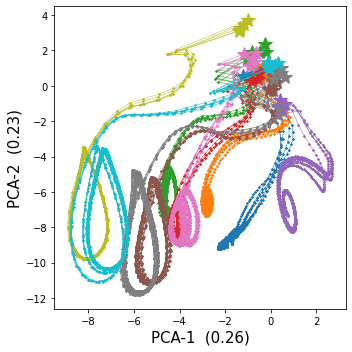

In [141]:
plot_latent_traj(ztL_te, show=True)

##### Node 

In [142]:
Xrec_te, ztL_te, _, _, C_base = node_base(test_batch,   L=plotL, T_custom=forecast_te*test_batch.shape[1])

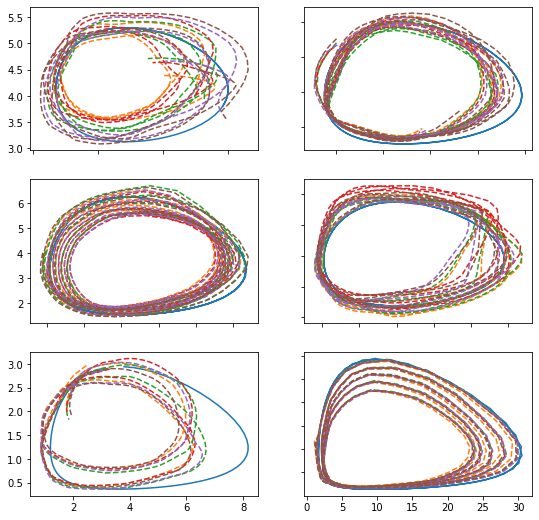

In [143]:
plot_2d(test_batch, Xrec_te, show=True)

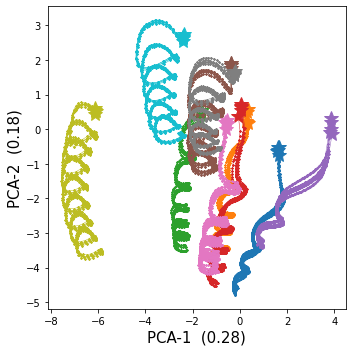

In [144]:
plot_latent_traj(ztL_te, show=True)

Contrastive Matrix Z

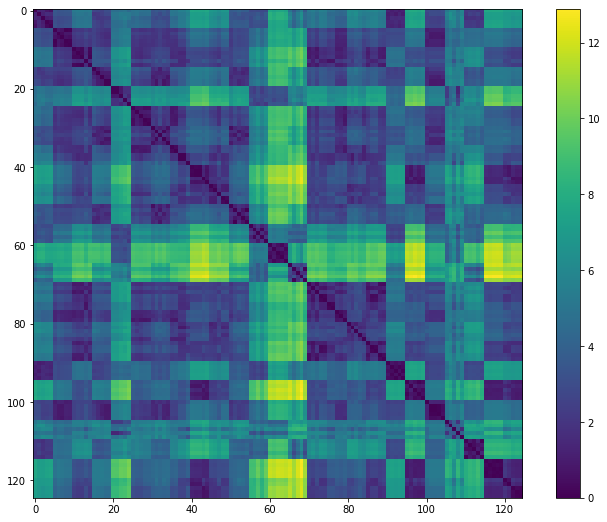

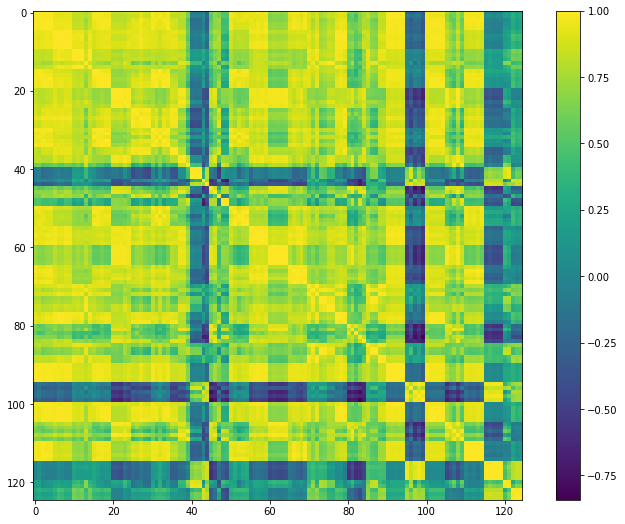

In [145]:
plot_C(C_full)

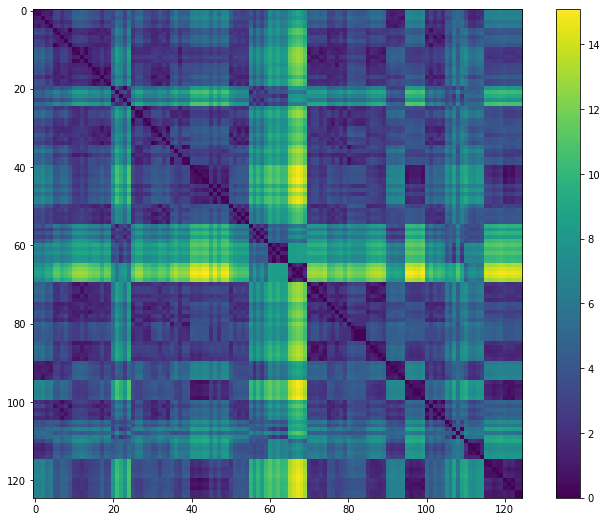

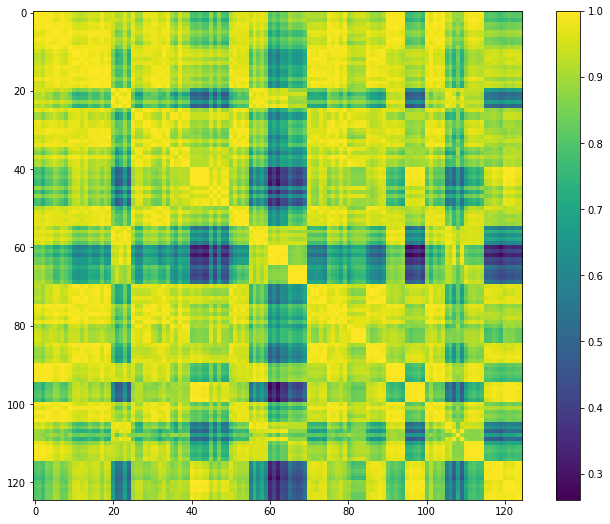

In [146]:
plot_C(C_inv)